In [13]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

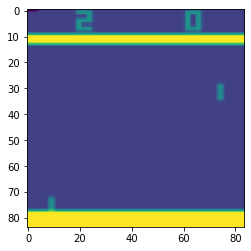

In [14]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [15]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.reshape(x.size(0), -1)))
        return self.fc5(x)


In [16]:
class Memory_Buffer(object):
    def __init__(self, memory_size=100000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [17]:
class DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [18]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.05
eps_decay = 30000
frames = 2000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, memory_size = max_buff)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_stackframe", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

D:\Softwares\anaconda3\envs\py37\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Softwares\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0
frames:  1000, reward: -20.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -20.500000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.666667, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.500000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.600000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.714286, loss: 0.000000, epsilon: 0.820543, episode:    7
frames:  7000, reward: -20.750000, loss: 0.000000, epsilon: 0.793971, episode:    8
frames:  8000, reward: -20.777778, loss: 0.000000, epsilon: 0.768269, episode:    9
frames:  9000, reward: -20.900000, loss: 0.000000, epsilon: 0.743410, episode:   11
frames: 10000, reward: -20.900000, loss: 0.016001, epsilon: 0.719366, episode:   12
frames: 11000, reward: -20.900000, loss: 0.000458, epsilon: 0.696110, episode:   

frames: 98000, reward: -20.600000, loss: 0.001436, epsilon: 0.047752, episode:  115
frames: 99000, reward: -20.600000, loss: 0.000898, epsilon: 0.046514, episode:  116
frames: 100000, reward: -20.700000, loss: 0.000720, epsilon: 0.045317, episode:  117
frames: 101000, reward: -20.700000, loss: 0.000382, epsilon: 0.044159, episode:  118
frames: 102000, reward: -20.700000, loss: 0.001637, epsilon: 0.043040, episode:  119
frames: 103000, reward: -20.600000, loss: 0.003110, epsilon: 0.041956, episode:  120
frames: 104000, reward: -20.400000, loss: 0.003492, epsilon: 0.040909, episode:  121
frames: 105000, reward: -20.400000, loss: 0.001239, epsilon: 0.039895, episode:  122
frames: 106000, reward: -20.300000, loss: 0.000485, epsilon: 0.038915, episode:  124
frames: 107000, reward: -20.400000, loss: 0.003168, epsilon: 0.037967, episode:  125
frames: 108000, reward: -20.400000, loss: 0.001665, epsilon: 0.037050, episode:  125
frames: 109000, reward: -20.100000, loss: 0.001003, epsilon: 0.0361

frames: 195000, reward: -16.400000, loss: 0.002594, epsilon: 0.011488, episode:  189
frames: 196000, reward: -16.400000, loss: 0.002122, epsilon: 0.011440, episode:  189
frames: 197000, reward: -16.200000, loss: 0.004345, epsilon: 0.011392, episode:  190
frames: 198000, reward: -16.200000, loss: 0.004849, epsilon: 0.011347, episode:  190
frames: 199000, reward: -15.900000, loss: 0.002643, epsilon: 0.011303, episode:  191
frames: 200000, reward: -15.900000, loss: 0.001229, epsilon: 0.011260, episode:  191
frames: 201000, reward: -14.800000, loss: 0.004481, epsilon: 0.011219, episode:  192
frames: 202000, reward: -14.800000, loss: 0.002413, epsilon: 0.011179, episode:  192
frames: 203000, reward: -13.800000, loss: 0.003865, epsilon: 0.011140, episode:  193
frames: 204000, reward: -13.800000, loss: 0.006109, epsilon: 0.011103, episode:  193
frames: 205000, reward: -13.600000, loss: 0.003437, epsilon: 0.011066, episode:  194
frames: 206000, reward: -13.600000, loss: 0.006738, epsilon: 0.01

frames: 292000, reward: -5.000000, loss: 0.001510, epsilon: 0.010059, episode:  231
frames: 293000, reward: -5.000000, loss: 0.003136, epsilon: 0.010057, episode:  231
frames: 294000, reward: -5.000000, loss: 0.001707, epsilon: 0.010055, episode:  231
frames: 295000, reward: -5.000000, loss: 0.003124, epsilon: 0.010053, episode:  231
frames: 296000, reward: -4.900000, loss: 0.002297, epsilon: 0.010051, episode:  232
frames: 297000, reward: -4.900000, loss: 0.001620, epsilon: 0.010050, episode:  232
frames: 298000, reward: -4.900000, loss: 0.002273, epsilon: 0.010048, episode:  232
frames: 299000, reward: -4.900000, loss: 0.002812, epsilon: 0.010046, episode:  232
frames: 300000, reward: -4.700000, loss: 0.005490, epsilon: 0.010045, episode:  233
frames: 301000, reward: -4.700000, loss: 0.002921, epsilon: 0.010043, episode:  233
frames: 302000, reward: -4.700000, loss: 0.001346, epsilon: 0.010042, episode:  233
frames: 303000, reward: -4.600000, loss: 0.001394, epsilon: 0.010041, episod

frames: 390000, reward: 0.000000, loss: 0.003318, epsilon: 0.010002, episode:  260
frames: 391000, reward: 0.000000, loss: 0.002204, epsilon: 0.010002, episode:  260
frames: 392000, reward: 0.000000, loss: 0.002704, epsilon: 0.010002, episode:  260
frames: 393000, reward: 1.300000, loss: 0.002784, epsilon: 0.010002, episode:  261
frames: 394000, reward: 1.300000, loss: 0.002304, epsilon: 0.010002, episode:  261
frames: 395000, reward: 1.300000, loss: 0.004415, epsilon: 0.010002, episode:  261
frames: 396000, reward: 2.200000, loss: 0.000767, epsilon: 0.010002, episode:  262
frames: 397000, reward: 2.200000, loss: 0.002339, epsilon: 0.010002, episode:  262
frames: 398000, reward: 2.200000, loss: 0.001350, epsilon: 0.010002, episode:  262
frames: 399000, reward: 3.500000, loss: 0.000914, epsilon: 0.010002, episode:  263
frames: 400000, reward: 3.500000, loss: 0.001782, epsilon: 0.010002, episode:  263
frames: 401000, reward: 3.500000, loss: 0.002356, epsilon: 0.010002, episode:  263
fram

frames: 489000, reward: 16.200000, loss: 0.000806, epsilon: 0.010000, episode:  297
frames: 490000, reward: 16.400000, loss: 0.002952, epsilon: 0.010000, episode:  298
frames: 491000, reward: 16.400000, loss: 0.000669, epsilon: 0.010000, episode:  298
frames: 492000, reward: 16.400000, loss: 0.002802, epsilon: 0.010000, episode:  298
frames: 493000, reward: 16.800000, loss: 0.001012, epsilon: 0.010000, episode:  299
frames: 494000, reward: 16.800000, loss: 0.000567, epsilon: 0.010000, episode:  299
frames: 495000, reward: 16.500000, loss: 0.000656, epsilon: 0.010000, episode:  300
frames: 496000, reward: 16.500000, loss: 0.000457, epsilon: 0.010000, episode:  300
frames: 497000, reward: 16.500000, loss: 0.000436, epsilon: 0.010000, episode:  301
frames: 498000, reward: 16.700000, loss: 0.001354, epsilon: 0.010000, episode:  302
frames: 499000, reward: 16.700000, loss: 0.003930, epsilon: 0.010000, episode:  302
frames: 500000, reward: 17.400000, loss: 0.000606, epsilon: 0.010000, episod

frames: 587000, reward: 12.400000, loss: 0.000598, epsilon: 0.010000, episode:  341
frames: 588000, reward: 12.400000, loss: 0.000227, epsilon: 0.010000, episode:  341
frames: 589000, reward: 13.200000, loss: 0.000818, epsilon: 0.010000, episode:  342
frames: 590000, reward: 13.200000, loss: 0.000805, epsilon: 0.010000, episode:  342
frames: 591000, reward: 13.100000, loss: 0.001194, epsilon: 0.010000, episode:  343
frames: 592000, reward: 13.000000, loss: 0.000661, epsilon: 0.010000, episode:  344
frames: 593000, reward: 13.000000, loss: 0.002571, epsilon: 0.010000, episode:  344
frames: 594000, reward: 13.000000, loss: 0.000640, epsilon: 0.010000, episode:  344
frames: 595000, reward: 14.200000, loss: 0.001762, epsilon: 0.010000, episode:  345
frames: 596000, reward: 14.200000, loss: 0.000350, epsilon: 0.010000, episode:  345
frames: 597000, reward: 15.300000, loss: 0.000819, epsilon: 0.010000, episode:  346
frames: 598000, reward: 15.300000, loss: 0.000557, epsilon: 0.010000, episod

frames: 685000, reward: 17.600000, loss: 0.000786, epsilon: 0.010000, episode:  387
frames: 686000, reward: 16.900000, loss: 0.000333, epsilon: 0.010000, episode:  388
frames: 687000, reward: 16.900000, loss: 0.000835, epsilon: 0.010000, episode:  388
frames: 688000, reward: 16.900000, loss: 0.001384, epsilon: 0.010000, episode:  389
frames: 689000, reward: 16.900000, loss: 0.000644, epsilon: 0.010000, episode:  389
frames: 690000, reward: 16.500000, loss: 0.000648, epsilon: 0.010000, episode:  390
frames: 691000, reward: 16.500000, loss: 0.000646, epsilon: 0.010000, episode:  390
frames: 692000, reward: 16.900000, loss: 0.000633, epsilon: 0.010000, episode:  391
frames: 693000, reward: 16.900000, loss: 0.000218, epsilon: 0.010000, episode:  391
frames: 694000, reward: 16.700000, loss: 0.001560, epsilon: 0.010000, episode:  392
frames: 695000, reward: 16.700000, loss: 0.000385, epsilon: 0.010000, episode:  392
frames: 696000, reward: 16.700000, loss: 0.000223, epsilon: 0.010000, episod

frames: 783000, reward: 17.000000, loss: 0.000882, epsilon: 0.010000, episode:  430
frames: 784000, reward: 17.000000, loss: 0.000531, epsilon: 0.010000, episode:  430
frames: 785000, reward: 17.000000, loss: 0.001317, epsilon: 0.010000, episode:  430
frames: 786000, reward: 17.400000, loss: 0.001411, epsilon: 0.010000, episode:  431
frames: 787000, reward: 17.400000, loss: 0.001159, epsilon: 0.010000, episode:  431
frames: 788000, reward: 17.700000, loss: 0.000461, epsilon: 0.010000, episode:  432
frames: 789000, reward: 17.700000, loss: 0.000536, epsilon: 0.010000, episode:  432
frames: 790000, reward: 17.700000, loss: 0.000350, epsilon: 0.010000, episode:  433
frames: 791000, reward: 17.700000, loss: 0.000567, epsilon: 0.010000, episode:  433
frames: 792000, reward: 17.600000, loss: 0.000698, epsilon: 0.010000, episode:  434
frames: 793000, reward: 17.600000, loss: 0.000472, epsilon: 0.010000, episode:  434
frames: 794000, reward: 17.600000, loss: 0.000565, epsilon: 0.010000, episod

frames: 881000, reward: 17.600000, loss: 0.000185, epsilon: 0.010000, episode:  470
frames: 882000, reward: 17.600000, loss: 0.000587, epsilon: 0.010000, episode:  470
frames: 883000, reward: 17.600000, loss: 0.005166, epsilon: 0.010000, episode:  471
frames: 884000, reward: 17.600000, loss: 0.000361, epsilon: 0.010000, episode:  471
frames: 885000, reward: 17.600000, loss: 0.000282, epsilon: 0.010000, episode:  471
frames: 886000, reward: 17.400000, loss: 0.001501, epsilon: 0.010000, episode:  472
frames: 887000, reward: 17.400000, loss: 0.000355, epsilon: 0.010000, episode:  472
frames: 888000, reward: 17.500000, loss: 0.000473, epsilon: 0.010000, episode:  473
frames: 889000, reward: 17.500000, loss: 0.000722, epsilon: 0.010000, episode:  473
frames: 890000, reward: 17.400000, loss: 0.000499, epsilon: 0.010000, episode:  474
frames: 891000, reward: 17.400000, loss: 0.001262, epsilon: 0.010000, episode:  474
frames: 892000, reward: 17.400000, loss: 0.000647, epsilon: 0.010000, episod

frames: 979000, reward: 17.900000, loss: 0.000399, epsilon: 0.010000, episode:  512
frames: 980000, reward: 17.900000, loss: 0.001210, epsilon: 0.010000, episode:  513
frames: 981000, reward: 17.900000, loss: 0.000654, epsilon: 0.010000, episode:  513
frames: 982000, reward: 17.900000, loss: 0.000593, epsilon: 0.010000, episode:  513
frames: 983000, reward: 18.000000, loss: 0.001259, epsilon: 0.010000, episode:  514
frames: 984000, reward: 18.000000, loss: 0.000258, epsilon: 0.010000, episode:  514
frames: 985000, reward: 18.000000, loss: 0.001165, epsilon: 0.010000, episode:  514
frames: 986000, reward: 18.100000, loss: 0.000472, epsilon: 0.010000, episode:  515
frames: 987000, reward: 18.100000, loss: 0.000391, epsilon: 0.010000, episode:  515
frames: 988000, reward: 18.300000, loss: 0.000209, epsilon: 0.010000, episode:  516
frames: 989000, reward: 18.300000, loss: 0.000810, epsilon: 0.010000, episode:  516
frames: 990000, reward: 18.200000, loss: 0.000343, epsilon: 0.010000, episod

frames: 1076000, reward: 18.500000, loss: 0.000467, epsilon: 0.010000, episode:  554
frames: 1077000, reward: 18.600000, loss: 0.000988, epsilon: 0.010000, episode:  555
frames: 1078000, reward: 18.600000, loss: 0.000565, epsilon: 0.010000, episode:  555
frames: 1079000, reward: 18.500000, loss: 0.000326, epsilon: 0.010000, episode:  556
frames: 1080000, reward: 18.500000, loss: 0.000333, epsilon: 0.010000, episode:  556
frames: 1081000, reward: 18.600000, loss: 0.000643, epsilon: 0.010000, episode:  557
frames: 1082000, reward: 18.600000, loss: 0.000319, epsilon: 0.010000, episode:  557
frames: 1083000, reward: 18.600000, loss: 0.000329, epsilon: 0.010000, episode:  557
frames: 1084000, reward: 19.000000, loss: 0.000367, epsilon: 0.010000, episode:  558
frames: 1085000, reward: 19.000000, loss: 0.000505, epsilon: 0.010000, episode:  558
frames: 1086000, reward: 19.100000, loss: 0.001216, epsilon: 0.010000, episode:  559
frames: 1087000, reward: 19.100000, loss: 0.000577, epsilon: 0.01

frames: 1173000, reward: 19.200000, loss: 0.000714, epsilon: 0.010000, episode:  600
frames: 1174000, reward: 19.200000, loss: 0.000301, epsilon: 0.010000, episode:  601
frames: 1175000, reward: 19.200000, loss: 0.000715, epsilon: 0.010000, episode:  601
frames: 1176000, reward: 19.200000, loss: 0.000239, epsilon: 0.010000, episode:  602
frames: 1177000, reward: 19.200000, loss: 0.000231, epsilon: 0.010000, episode:  602
frames: 1178000, reward: 19.200000, loss: 0.000218, epsilon: 0.010000, episode:  603
frames: 1179000, reward: 19.200000, loss: 0.000220, epsilon: 0.010000, episode:  603
frames: 1180000, reward: 19.500000, loss: 0.000216, epsilon: 0.010000, episode:  604
frames: 1181000, reward: 19.500000, loss: 0.000265, epsilon: 0.010000, episode:  604
frames: 1182000, reward: 19.500000, loss: 0.000156, epsilon: 0.010000, episode:  605
frames: 1183000, reward: 19.500000, loss: 0.000439, epsilon: 0.010000, episode:  605
frames: 1184000, reward: 19.500000, loss: 0.000172, epsilon: 0.01

frames: 1270000, reward: 17.500000, loss: 0.000180, epsilon: 0.010000, episode:  643
frames: 1271000, reward: 17.500000, loss: 0.000367, epsilon: 0.010000, episode:  643
frames: 1272000, reward: 17.500000, loss: 0.000215, epsilon: 0.010000, episode:  643
frames: 1273000, reward: 17.700000, loss: 0.000867, epsilon: 0.010000, episode:  644
frames: 1274000, reward: 17.700000, loss: 0.000387, epsilon: 0.010000, episode:  644
frames: 1275000, reward: 17.800000, loss: 0.000549, epsilon: 0.010000, episode:  645
frames: 1276000, reward: 17.800000, loss: 0.000587, epsilon: 0.010000, episode:  645
frames: 1277000, reward: 17.200000, loss: 0.000319, epsilon: 0.010000, episode:  646
frames: 1278000, reward: 17.200000, loss: 0.000815, epsilon: 0.010000, episode:  646
frames: 1279000, reward: 17.200000, loss: 0.000584, epsilon: 0.010000, episode:  646
frames: 1280000, reward: 17.900000, loss: 0.000311, epsilon: 0.010000, episode:  647
frames: 1281000, reward: 17.900000, loss: 0.000816, epsilon: 0.01

frames: 1367000, reward: 17.100000, loss: 0.000356, epsilon: 0.010000, episode:  684
frames: 1368000, reward: 17.400000, loss: 0.002864, epsilon: 0.010000, episode:  685
frames: 1369000, reward: 17.400000, loss: 0.000309, epsilon: 0.010000, episode:  685
frames: 1370000, reward: 17.700000, loss: 0.000807, epsilon: 0.010000, episode:  686
frames: 1371000, reward: 17.700000, loss: 0.000389, epsilon: 0.010000, episode:  686
frames: 1372000, reward: 17.500000, loss: 0.000781, epsilon: 0.010000, episode:  687
frames: 1373000, reward: 17.500000, loss: 0.000593, epsilon: 0.010000, episode:  687
frames: 1374000, reward: 17.500000, loss: 0.000920, epsilon: 0.010000, episode:  688
frames: 1375000, reward: 17.500000, loss: 0.000615, epsilon: 0.010000, episode:  688
frames: 1376000, reward: 17.500000, loss: 0.000515, epsilon: 0.010000, episode:  689
frames: 1377000, reward: 17.500000, loss: 0.000636, epsilon: 0.010000, episode:  689
frames: 1378000, reward: 17.500000, loss: 0.000640, epsilon: 0.01

frames: 1464000, reward: 17.100000, loss: 0.000379, epsilon: 0.010000, episode:  725
frames: 1465000, reward: 17.100000, loss: 0.000514, epsilon: 0.010000, episode:  725
frames: 1466000, reward: 17.100000, loss: 0.000371, epsilon: 0.010000, episode:  725
frames: 1467000, reward: 17.600000, loss: 0.000409, epsilon: 0.010000, episode:  726
frames: 1468000, reward: 17.600000, loss: 0.000371, epsilon: 0.010000, episode:  726
frames: 1469000, reward: 17.600000, loss: 0.000247, epsilon: 0.010000, episode:  727
frames: 1470000, reward: 17.600000, loss: 0.000285, epsilon: 0.010000, episode:  727
frames: 1471000, reward: 17.600000, loss: 0.000178, epsilon: 0.010000, episode:  727
frames: 1472000, reward: 17.100000, loss: 0.000854, epsilon: 0.010000, episode:  728
frames: 1473000, reward: 17.100000, loss: 0.000397, epsilon: 0.010000, episode:  728
frames: 1474000, reward: 16.600000, loss: 0.000205, epsilon: 0.010000, episode:  729
frames: 1475000, reward: 16.600000, loss: 0.000396, epsilon: 0.01

frames: 1561000, reward: 20.100000, loss: 0.000233, epsilon: 0.010000, episode:  768
frames: 1562000, reward: 20.100000, loss: 0.000373, epsilon: 0.010000, episode:  768
frames: 1563000, reward: 19.400000, loss: 0.000196, epsilon: 0.010000, episode:  769
frames: 1564000, reward: 19.400000, loss: 0.000187, epsilon: 0.010000, episode:  770
frames: 1565000, reward: 19.400000, loss: 0.000677, epsilon: 0.010000, episode:  770
frames: 1566000, reward: 19.400000, loss: 0.000319, epsilon: 0.010000, episode:  770
frames: 1567000, reward: 19.400000, loss: 0.000140, epsilon: 0.010000, episode:  771
frames: 1568000, reward: 19.400000, loss: 0.000190, epsilon: 0.010000, episode:  771
frames: 1569000, reward: 19.400000, loss: 0.000207, epsilon: 0.010000, episode:  772
frames: 1570000, reward: 19.400000, loss: 0.000194, epsilon: 0.010000, episode:  772
frames: 1571000, reward: 19.800000, loss: 0.000226, epsilon: 0.010000, episode:  773
frames: 1572000, reward: 19.700000, loss: 0.000490, epsilon: 0.01

frames: 1658000, reward: 19.900000, loss: 0.000749, epsilon: 0.010000, episode:  811
frames: 1659000, reward: 19.900000, loss: 0.001851, epsilon: 0.010000, episode:  812
frames: 1660000, reward: 19.900000, loss: 0.000212, epsilon: 0.010000, episode:  812
frames: 1661000, reward: 19.700000, loss: 0.000134, epsilon: 0.010000, episode:  813
frames: 1662000, reward: 19.700000, loss: 0.000654, epsilon: 0.010000, episode:  813
frames: 1663000, reward: 19.500000, loss: 0.000220, epsilon: 0.010000, episode:  814
frames: 1664000, reward: 19.500000, loss: 0.000125, epsilon: 0.010000, episode:  814
frames: 1665000, reward: 19.400000, loss: 0.001163, epsilon: 0.010000, episode:  815
frames: 1666000, reward: 19.500000, loss: 0.000111, epsilon: 0.010000, episode:  816
frames: 1667000, reward: 19.500000, loss: 0.000226, epsilon: 0.010000, episode:  816
frames: 1668000, reward: 19.500000, loss: 0.000221, epsilon: 0.010000, episode:  816
frames: 1669000, reward: 19.300000, loss: 0.000174, epsilon: 0.01

frames: 1755000, reward: 20.500000, loss: 0.000174, epsilon: 0.010000, episode:  856
frames: 1756000, reward: 20.500000, loss: 0.000217, epsilon: 0.010000, episode:  857
frames: 1757000, reward: 20.300000, loss: 0.000096, epsilon: 0.010000, episode:  858
frames: 1758000, reward: 20.300000, loss: 0.000125, epsilon: 0.010000, episode:  858
frames: 1759000, reward: 20.300000, loss: 0.000130, epsilon: 0.010000, episode:  858
frames: 1760000, reward: 20.200000, loss: 0.000112, epsilon: 0.010000, episode:  859
frames: 1761000, reward: 20.200000, loss: 0.000069, epsilon: 0.010000, episode:  859
frames: 1762000, reward: 19.900000, loss: 0.000297, epsilon: 0.010000, episode:  860
frames: 1763000, reward: 19.900000, loss: 0.000266, epsilon: 0.010000, episode:  860
frames: 1764000, reward: 20.000000, loss: 0.000110, epsilon: 0.010000, episode:  861
frames: 1765000, reward: 20.000000, loss: 0.000083, epsilon: 0.010000, episode:  861
frames: 1766000, reward: 20.000000, loss: 0.000132, epsilon: 0.01

frames: 1852000, reward: 19.800000, loss: 0.000099, epsilon: 0.010000, episode:  901
frames: 1853000, reward: 19.800000, loss: 0.000099, epsilon: 0.010000, episode:  901
frames: 1854000, reward: 19.800000, loss: 0.000103, epsilon: 0.010000, episode:  901
frames: 1855000, reward: 19.800000, loss: 0.000130, epsilon: 0.010000, episode:  902
frames: 1856000, reward: 19.800000, loss: 0.000118, epsilon: 0.010000, episode:  902
frames: 1857000, reward: 19.800000, loss: 0.000188, epsilon: 0.010000, episode:  902
frames: 1858000, reward: 20.000000, loss: 0.000055, epsilon: 0.010000, episode:  903
frames: 1859000, reward: 20.000000, loss: 0.000995, epsilon: 0.010000, episode:  904
frames: 1860000, reward: 20.000000, loss: 0.000101, epsilon: 0.010000, episode:  904
frames: 1861000, reward: 19.900000, loss: 0.000101, epsilon: 0.010000, episode:  905
frames: 1862000, reward: 19.900000, loss: 0.000167, epsilon: 0.010000, episode:  905
frames: 1863000, reward: 19.800000, loss: 0.000090, epsilon: 0.01

frames: 1949000, reward: 20.400000, loss: 0.000184, epsilon: 0.010000, episode:  947
frames: 1950000, reward: 20.400000, loss: 0.000644, epsilon: 0.010000, episode:  947
frames: 1951000, reward: 20.200000, loss: 0.000183, epsilon: 0.010000, episode:  948
frames: 1952000, reward: 20.200000, loss: 0.000117, epsilon: 0.010000, episode:  948
frames: 1953000, reward: 20.200000, loss: 0.000082, epsilon: 0.010000, episode:  948
frames: 1954000, reward: 20.200000, loss: 0.000134, epsilon: 0.010000, episode:  949
frames: 1955000, reward: 20.200000, loss: 0.000211, epsilon: 0.010000, episode:  949
frames: 1956000, reward: 20.300000, loss: 0.000120, epsilon: 0.010000, episode:  950
frames: 1957000, reward: 20.300000, loss: 0.000085, epsilon: 0.010000, episode:  950
frames: 1958000, reward: 20.200000, loss: 0.000061, epsilon: 0.010000, episode:  951
frames: 1959000, reward: 20.200000, loss: 0.000074, epsilon: 0.010000, episode:  951
frames: 1960000, reward: 20.500000, loss: 0.000076, epsilon: 0.01

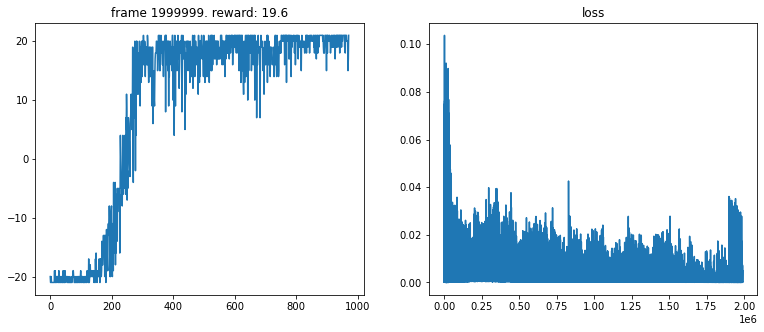

In [19]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)